In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Processing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Metrics and validation
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
# Function to process data
def process_data(file_name):
    
    # Read in the data
    df = pd.read_csv(file_name)
    
    # Revome .csv from filename to make it column
    col = file_name.replace(".csv", "")
        
    # Convert Time
    df.Time = pd.to_datetime(df.Time)
    
    # Rename the value column
    df.columns = ["time", col]
    
    # Remove K and multiply by 1000 if any. And set time as index
    df[col] = df[col].astype("str")
    df[col] = np.where(df[col].str.contains("K"), df[col].str.replace("K", "").astype("float")*1000, df[col])
    return df.set_index("time")


# List all the files
files_to_read = glob.glob("Data/*.csv*")

# Apply the function
df = pd.concat(list(map(process_data, files_to_read)), axis=1).dropna()

# Change column names
df.columns = df.columns.str.split("\\").str[-1]

# Change dtypes
df = df.apply(pd.to_numeric, errors="coerce")

# # Apply interpolation
df = df.interpolate()

# # Apply backfill
df = df.fillna(method="bfill")


# Set time column again
df = df.reset_index()


# Create date time related columns
df.insert(loc=1, column="date", value=pd.to_datetime(df.time.dt.date))
df.insert(loc=2, column="hour", value=df.time.dt.hour)
df.insert(loc=3, column="day_of_week", value=df.date.dt.day_name())
df.insert(loc=4, column="week_of_year", value=df.date.dt.isocalendar().week)
df.insert(loc=5, column="day_of_year", value=df.date.dt.dayofyear)
df.insert(loc=6, column="day_of_month", value=df.date.dt.day)
df.insert(loc=7, column="quarter", value=df.date.dt.quarter)

# Create internal variables
df["previous_day"] = df.lmp_dam.shift(24)
df["previous_week"] = df.lmp_dam.shift(168)
df["previous_hour"] = df.lmp_dam.shift(1)
df = df.dropna()

In [3]:
# Initialize all the models we're interested in
seed = 43
linear = LinearRegression(n_jobs=-1)
knn = KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
dt = DecisionTreeRegressor(random_state=seed)
svm = SVR()

rf =  RandomForestRegressor(n_jobs=-1, random_state=seed)
et = ExtraTreesRegressor(n_jobs=-1, random_state=seed)
gb = GradientBoostingRegressor(random_state=seed)
xgb = XGBRegressor(random_state=seed, n_jobs=-1)
lgb = LGBMRegressor(random_state=seed, n_jobs=-1)
cat = CatBoostRegressor(silent=True)

# Models dict
models = {
    "linear":linear,
    "knn":knn,
    "dt":dt,
    "svm":svm,
    "rf":rf,
    "et":et,
    "gb":gb,
    "xgb":xgb,
    "lgb":lgb,
    "cat":cat
}

In [4]:
# Set training and prediction date
training_start = "2021-01-01"
training_end = "2022-01-31"

# Prediction interval
test_start = "2022-02-01"
test_end = "2022-02-10"

features_to_use = ["caiso_tac_load_2da", "hour", "sce_gas_price_rt", "sp15_feels_like_rt", "sp15_temp_rt",
                   "previous_day", "previous_week", "previous_hour", "gen_solar_rt",
                   "zp26_solar_gen_7da", "sp15_solar_gen_7da", "np15_wind_speed_rt"]

X_train = df[df.date.between(training_start, training_end)][features_to_use]
Y_train = df[df.date.between(training_start, training_end)].lmp_dam

X_test = df[df.date.between(test_start, test_end)][features_to_use]
Y_test = df[df.date.between(test_start, test_end)].lmp_dam


def make_prediction(model):
    
    # Create pipeline
    pipeline = make_pipeline(StandardScaler(), models[model])
    
    # Fit and predict
    pipeline.fit(X_train, Y_train)
    pred = pipeline.predict(X_test)
    
    # Create actual vs prediction df
    actu_pred_df = pd.DataFrame({
        "actual":Y_test,
        f"{model}":pred
    }).reset_index(drop=True)
    
    # Insert date of prediction
    actu_pred_df.insert(loc=0, value=df[df.date.between(test_start, test_end)].time.reset_index(drop=True), column="date")
    
    # Set actual and date as index.
    # Before setting multi index, keep into anto another variable. Otherwise it can't find column
    actu_pred_df_m = actu_pred_df.set_index(["date", "actual"])
    return actu_pred_df_m


# Apply the function on all the models to predict and calculate mape
pred_df = pd.concat(list(map(make_prediction, models.keys())), axis=1).reset_index()

# Calculate mape
def cal_mape(model):
    mape = mean_absolute_percentage_error(pred_df.actual, pred_df[model])
    mape = round((mape*100), 2)
    mape_df = pd.DataFrame({
        "models":model,
        "mape(%)":mape
    }, index=[0])
    return mape_df

# Apply the function to find mape
mape_df = pd.concat(list(map(cal_mape, pred_df.columns[2:]))).reset_index(drop=True)
mape_df

,models,mape(%)
0,linear,16.47
1,knn,13.79
2,dt,11.44
3,svm,9.05
4,rf,8.18
5,et,7.36
6,gb,9.60
7,xgb,7.66
8,lgb,7.46
9,cat,7.90


#### Let's plot the best performers against the actual data

In [5]:
# Plot actual vs predicted
pred_df["temp_date"] = pd.to_datetime(pred_df.date.dt.date)

In [6]:
# We will create a function to plot
def plot_forecast_vs_actual(model, date):
    title = f"{model.upper()} Prediction vs Actual for {date}"
    pred_df[pred_df.temp_date==date].drop("temp_date", axis=1)\
    .set_index("date")[["actual", model]].plot(title=title, figsize=(17, 7), xlabel="Date", ylabel="LMP($)")

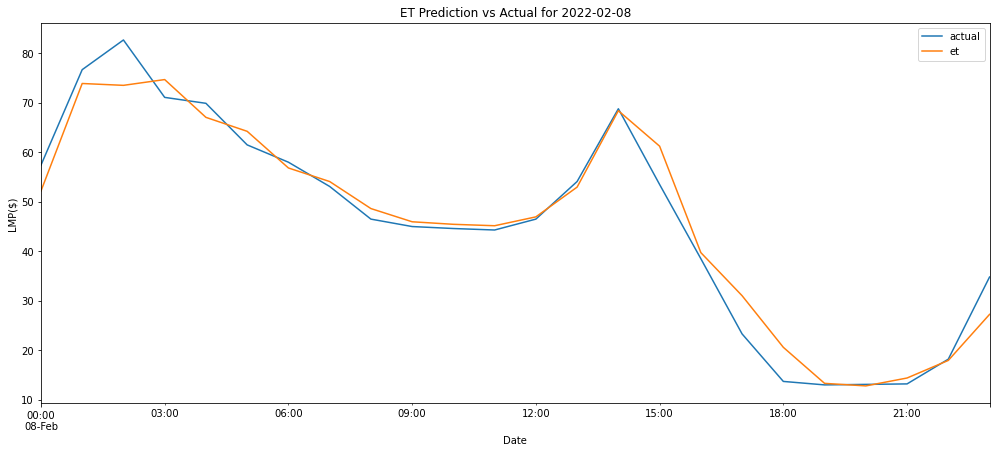

In [7]:
# ET vs actual. We will see the curve for 1 day
plot_forecast_vs_actual("et", "2022-02-08")

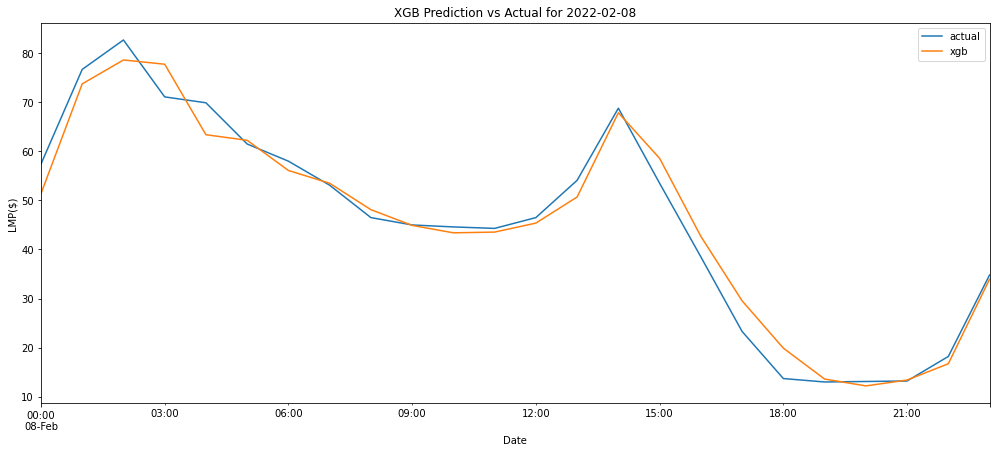

In [8]:
# xgb vs actual
plot_forecast_vs_actual("xgb", "2022-02-08")

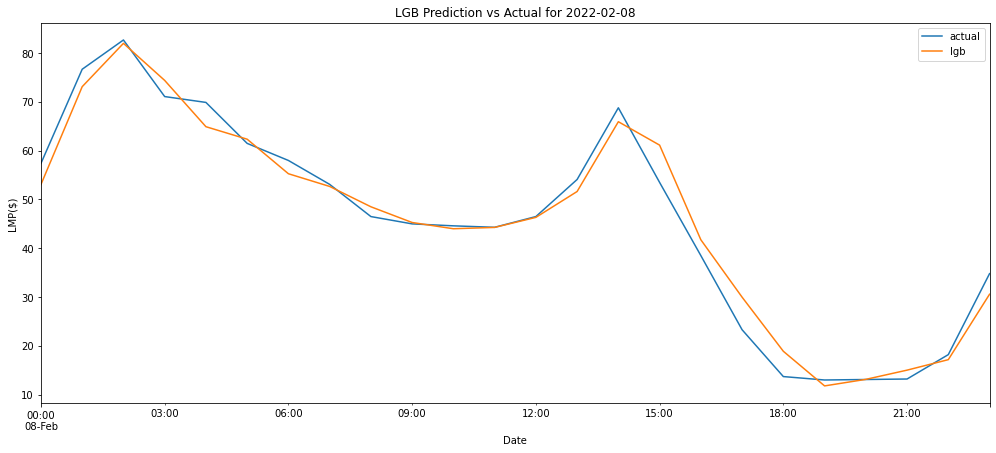

In [9]:
# lgb vs actual
plot_forecast_vs_actual("lgb", "2022-02-08")

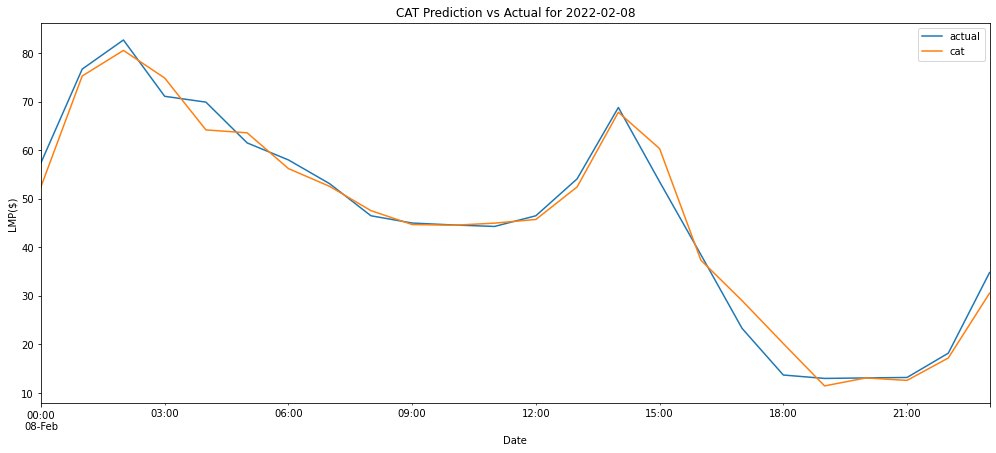

In [10]:
# cat vs actual
plot_forecast_vs_actual("cat", "2022-02-08")

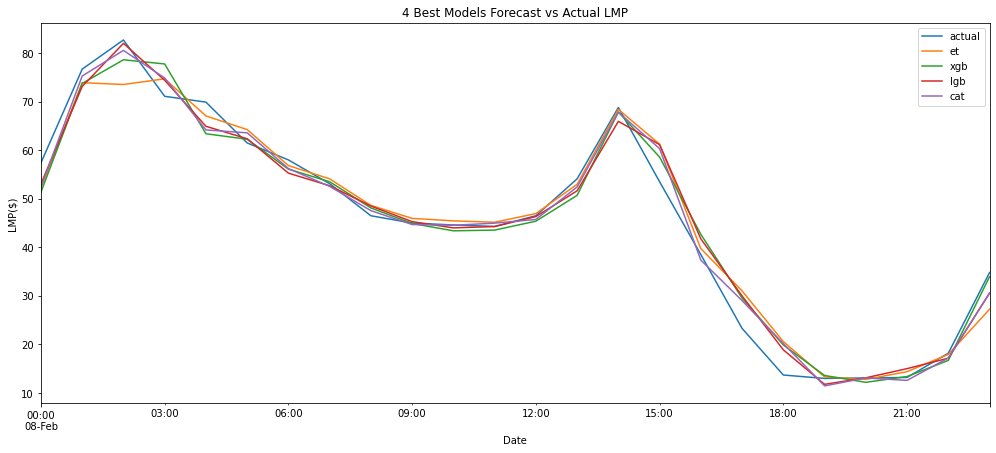

In [11]:
# Or we can plot them all
pred_df[pred_df.temp_date=="2022-02-08"].drop("temp_date", axis=1)\
.set_index("date")[["actual", "et", "xgb", "lgb", "cat"]].plot(title="4 Best Models Forecast vs Actual LMP", 
                                                               figsize=(17, 7), xlabel="Date", ylabel="LMP($)")
plt.show()